<a href="https://colab.research.google.com/github/AnnaVitali/Neuro_Symbolic_AI_example/blob/master/Neuro_SymbolicAI_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install LTNtorch

In [2]:
import torch
import ltn
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split

In [3]:
df = pd.read_csv('/content/wine_dataset.csv') # load data
df.drop('quality', axis = 1, inplace = True) # we want a binary classification problem
df['style'] = np.where(df['style'] == 'red', True, False) # change red and withe in true or false
df = df.sample(frac = 1) # shuffle the data taking a sample of the 100%

## Utility Class

In [4]:
class DataLoader(object):
  # constructor
  def __init__(self, data, labels, batch_size=1, shuffle=True):
    self.data = data
    self.labels = labels
    self.batch_size = batch_size
    self.shuffle = shuffle

  # return the number of batches
  def __len__(self):
    return int (np.ceil(self.data.shape[0] / self.batch_size))

  # describes the logic to run when we iterate over any instance of this class
  def __iter__(self):
    n = self.data.shape[0]
    idx_pos = np.where(self.labels == 1)[0]
    idx_neg = np.where(self.labels == 0)[0]
    np.random.shuffle(idx_pos)
    np.random.shuffle(idx_neg)

    for start_idx in range(0, n, self.batch_size):
      end_idx = min(start_idx + self.batch_size, n)

      # get one positive and one negative sample for each bace, to keep the class balanced
      pos_batch_size = min(self.batch_size // 2, len(idx_pos))
      neg_batch_size = self.batch_size - pos_batch_size
      pos_idx = idx_pos[:pos_batch_size]
      neg_idx = np.random.choice(idx_neg, size = neg_batch_size, replace = False)

      idx = np.concatenate([pos_idx, neg_idx])
      np.random.shuffle(idx)
      data = self.data[idx]
      labels = self.labels[idx]
      yield data, labels

In [5]:
class ModelA(torch.nn.Module):
  def __init__(self):
    super(ModelA, self).__init__()

    # model definition

    self.sigmoid = torch.nn.Sigmoid()

    self.layer1 = torch.nn.Linear(11, 64)
    self.layer2 = torch.nn.Linear(64, 64)
    self.layer3 = torch.nn.Linear(64, 1)

    self.relu = torch.nn.ReLU()
    self.dropout  = torch.nn.Dropout(p = 0.1)

  def forward(self, x):
    x = self.relu(self.layer1(x))
    x = self.relu(self.layer2(x))
    x = self.dropout(x)
    return self.sigmoid(self.layer3(x))

## Logic Tensor Network (LTN)

We need to split the sataset into features and labels and then split them into training and testing sets. We standardize our feaures to have a zero mean and unit variance, thus remove scale influence (fo example the siparity between a feature measuring a person's age and another calculating their salary) and to help the NN converge faster

In [6]:
features = df.drop('style', axis = 1).values
features = (features - features.mean()) / features.std()

In [7]:
features = torch.tensor(features).to(dtype=torch.float32)
labels = torch.tensor(df['style'].values).to(dtype=torch.float32)

We create the taining and testing dataloader, using a batch-size of 64. we tak the first 91 samples as part of our training set and the remaining for testing. We restrict the training set to such a small amount to higlight the power of NSAI when it comes to small data.

In [8]:
train_loader = DataLoader(features[:91], labels[:91], 64, True)
test_loader = DataLoader(features[91:], labels[91:], 64, False)

### Defining the kwnoledge base and the Neural Netork Architecture
The next thing to do now, is to extract the kwnoledge base (axioms), and create the Neural Network. we define our predicate, the connecive and the quantifiers.

We define our **predicate** as a simple fedd-forward neural network of three layer:
- input layer (12, 64), translating the dataset's 11 features to 64 neurons
- hidden layer with 64 neurons
- output layer converging to a single neuron

we define a NOT connective and a FOR ALL quantifier. These are the recommended settings by LTNtorch for binary classification.


In [9]:
A = ltn.Predicate(ModelA())

# create the NOT standard connective
# connective modules contributes to kwnoledge-base extraction by amalgamating aub-formulas with different features
Not = ltn.Connective(ltn.fuzzy_ops.NotStandard())

# create the FOR ALL quantifier
# quantifier module determines the formula dimensions for tensor aggregation
Forall = ltn.Quantifier(ltn.fuzzy_ops.AggregPMeanError(p = 2), quantifier = "f")

### Training the Logic tensor Network

We need a way to evaluate our system, for doing so we consider two aspects:

- the kwnoledge-base satisfaction level (SAT), this metric answer the question of how good the LTN is at learning. We will use this throughout the training process as part of our loss function (maximizing it)
- the classification performance, tell us the overall performnce of the model

In [10]:
def compute_sat_level(loader):
  mean_sat = 0
  for data, labels in loader:
    # get positive samples
    x_A = ltn.Variable("x_A", data[torch.nonzero(labels)])
    # get our negative samples
    x_not_A = ltn.Variable("x_not_A", data[torch.nonzero(torch.logical_not(labels))])

    # get the mean SAT of both sample types
    mean_sat += SatAgg(Forall(x_A, A(x_A)), Forall(x_not_A, Not(A(x_not_A)))
    )

  # get the mean SAT over all samples
  mean_sat /= len(loader)
  return mean_sat

def compute_accuracy(loader):
  mean_accuracy = 0.0

  for data, labels in loader:
    predictions = A.model(data).detach().numpy()

    # convert to a binary classification
    predictions = np.where(predictions > 0.5, 1., 0.).flatten()

    # compute the accuracy score
    mean_accuracy += accuracy_score(labels, predictions)

  return mean_accuracy / len(loader)

In [11]:
SatAgg = ltn.fuzzy_ops.SatAgg()
optimizer = torch.optim.Adam(A.parameters(), lr=0.001)

In [12]:
EPOCHS: int = 100

for epoch  in range(EPOCHS):
  # reset the training loss for every epoch

  train_loss = 0.0

  #start batching the data
  for batch_idx, (data, labels) in enumerate(train_loader):
    optimizer.zero_grad()

    # ground the variables with current batch data
    x_A = ltn.Variable("x_A", data[torch.nonzero(labels)])
    x_not_A = ltn.Variable("x_not_A", data[torch.nonzero(torch.logical_not(labels))])

    sat_agg = SatAgg(Forall(x_A, A(x_A)),
                      Forall(x_not_A, Not(A(x_not_A))))

    # compute loss and perform backpropagation
    loss = 1. - sat_agg
    loss.backward()
    optimizer.step()
    train_loss += loss.item()

  # monitor the training loss
  train_loss = train_loss / len(train_loader)

  if epoch % 20 == 0 :
    print(" epoch %d | loss %.4f | Train Sat %.3f | Test Sat %.3f | Train Acc %.3f | Test Acc %.3f"
          %(epoch, train_loss, compute_sat_level(train_loader), compute_sat_level(test_loader),
            compute_accuracy(train_loader), compute_accuracy(test_loader)))

 epoch 0 | loss 0.4999 | Train Sat 0.509 | Test Sat 0.509 | Train Acc 0.562 | Test Acc 0.600
 epoch 20 | loss 0.3216 | Train Sat 0.687 | Test Sat 0.696 | Train Acc 0.930 | Test Acc 0.919
 epoch 40 | loss 0.2334 | Train Sat 0.791 | Test Sat 0.690 | Train Acc 0.945 | Test Acc 0.871
 epoch 60 | loss 0.1862 | Train Sat 0.793 | Test Sat 0.663 | Train Acc 0.945 | Test Acc 0.892
 epoch 80 | loss 0.2182 | Train Sat 0.817 | Test Sat 0.680 | Train Acc 0.961 | Test Acc 0.916


## Prediction Stacking

Previously we focused on representing kwnoledge as axioms and we feed this representation to the NN to map the relationship between the various dimensions to learn kwnoledge. Another way to extract kwnoledge in the form of symbolic statements is by using decision trees.

We can combine prediction obtained by the DT and stack them on top of those generated by the NN. By stacking we mean combining all predictions from both techniques and performing an aggregation.

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import StackingClassifier

In [14]:
df = pd.read_csv('/content/wine_dataset.csv')
df.drop('quality', axis = 1, inplace = True)
df['style'] = np.where(df['style'] == 'red', True, False)
df = df.sample(frac=1)
features = df.drop('style', axis=1)
features = (features - features.mean()) / features.std()
labels = df['style']

In [15]:
x_train, x_test, y_train, y_test = train_test_split(features,labels, test_size = 0.2, random_state = 42)

### Training the model

We first create a DT and a NN, then we need to define our stacking classifier. We will set the DT as the base estimator and the NN as the final estimator

In [16]:
dt = DecisionTreeClassifier(random_state=42)
nn = MLPClassifier(hidden_layer_sizes=(64,), random_state=42)

estimators = [('dt', dt), ('nn', nn)]
stacking_clf = StackingClassifier(estimators=estimators, final_estimator=nn)

In [17]:
stacking_clf.fit(x_train, y_train)

StackingClassifier(estimators=[('dt', DecisionTreeClassifier(random_state=42)),
                               ('nn',
                                MLPClassifier(hidden_layer_sizes=(64,),
                                              random_state=42))],
                   final_estimator=MLPClassifier(hidden_layer_sizes=(64,),
                                                 random_state=42))

In [18]:
print(f"Accuracy: {stacking_clf.score(x_test, y_test):.3f}")

Accuracy: 0.995


### Preidciotn interpretability and logic tracing

In [19]:
from sklearn.tree import export_text

# get the decision tree classifier from stacking classifier
dt_clf = stacking_clf.estimators_[0]

# convert the decision tree unsing export text
tree_rules = export_text(dt_clf, feature_names = x_train.columns.tolist())

# parse the text representation of the rules to create a list of rules

rule_list = [rule.strip() for rule in tree_rules.split('\n') if rule.strip()]

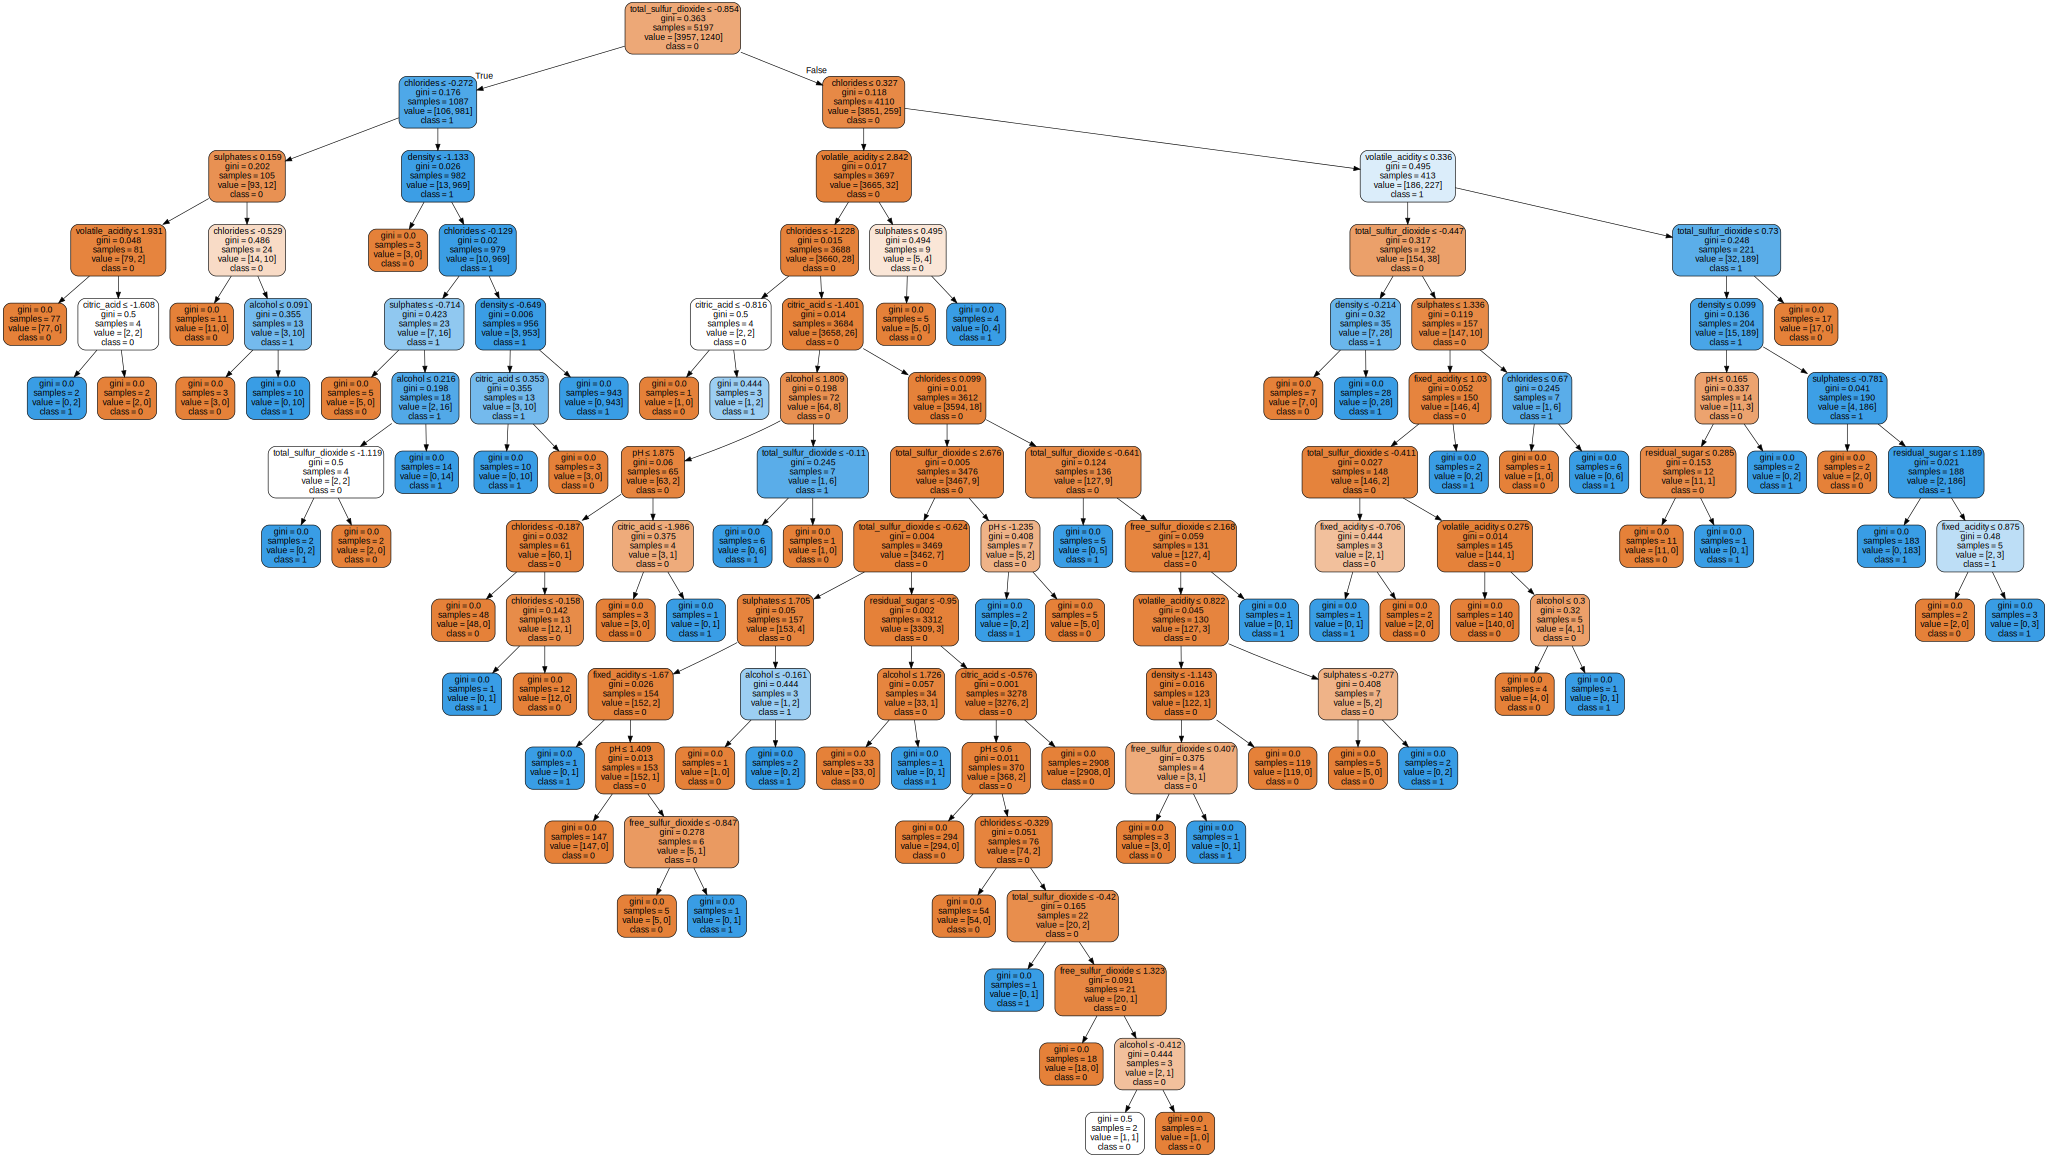

In [20]:
from sklearn.tree import export_graphviz
import graphviz

# export the decision tree as a Graphviz file

dot_data = export_graphviz(dt_clf, out_file=None,
                           feature_names = x_train.columns,
                           class_names=['0', '1'],
                           filled = True, rounded = True,
                           special_characters = True)

graph = graphviz.Source(dot_data)

# show the decision tree
graph